# Problem Statement: **Hyperparameter Tuning for AtliQ’s Fashion Item Classifier**

### AtliQ Fashion wants to develop a neural network to classify fashion items using the FashionMNIST dataset. Your task is to optimize the neural network's performance by fine-tuning its hyperparameters. We will be using **FashionMNIST** dataset but since the dataset is large, we will work with only a subset to ensure that the solution is computationally feasible.

**References:**

* transforms.Compose (PyTorch): [Link](https://pytorch.org/vision/master/generated/torchvision.transforms.Compose.html)
* Optuna (Hyperparameter Optimization Framework) [Link](https://optuna.readthedocs.io/en/stable/)

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import random

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


c:\Users\ahmad\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




---



**Dataset Overview**

* Dataset: FashionMNIST
* Classes: 10 (e.g., T-shirts, trousers, shoes)
* Training Images: Subset of 10,000 (randomly sampled from 60,000)
* Test Images: Subset of 2,000 (randomly sampled from 10,000)



---



**Step1**: Load and Sample the Dataset

* Load the FashionMNIST dataset using torchvision.datasets.
* Sample 10,000 images for training and 2,000 images for testing.
* Normalize the pixel values to the range [-1, 1].
* Create PyTorch DataLoaders for the training and test sets.

In [3]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Centers the pixel values around 0 and scales them to [-1, 1]
])

# Load FashionMNIST dataset

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



# Sample the datset

train_subset_size = 10_000
test_subset_size = 2_000


100%|██████████| 26.4M/26.4M [00:00<00:00, 34.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.14MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 17.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]




---



**Step2**: Create Dataloaders

* batch size = 32


In [4]:
train_subset, _ = random_split(dataset, [train_subset_size, len(dataset) - train_subset_size])
test_subset, _ = random_split(test_dataset, [test_subset_size, len(test_dataset) - test_subset_size])

In [5]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)

In [6]:
print(f"Training data size: {len(train_subset)}")
print(f"Testing data size: {len(test_subset)}")

Training data size: 10000
Testing data size: 2000




---



**Step3**: Define the Neural Network

* Create a fully connected feed-forward neural network (no CNN).

Structure:
* Input layer: 784 neurons (28x28 image flattened).
* 1st hidden layer: 128 neurons with ReLU activation.
* 2nd hidden layer: 64 neurons with ReLU activation.
* Output layer: 10 neurons (one for each class) with Softmax activation.

Use `nn.Sequential`

In [11]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        self.network = nn.Sequential(
            # Flatten the input tensor
            nn.Flatten(),
            # Input layer (784)
            nn.Linear(28*28, 128),
            # Activation
            nn.ReLU(),
            # Hidden layer 1
            nn.Linear(128, 64),
            # Activation
            nn.ReLU(),
            # Output layer (10 classes)
            nn.Linear(64, 10),
            # Softmax for probabilities
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.network(x)

model = FashionNN()
print(model)

FashionNN(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)




---



**Step 3**: Train the Base Model

Instructions:

Set the following base hyperparameters:
* Loss function: Cross Entropy Loss
* Learning rate: 0.01
* Batch size: 32
* Optimizer: SGD
* Epochs: 100

Train the model and record the training/validation accuracy and loss.


In [12]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        loss = loss_function(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Append the training loss
        train_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 2.2967
Epoch 2/100, Loss: 2.2744
Epoch 3/100, Loss: 2.2111
Epoch 4/100, Loss: 2.1132
Epoch 5/100, Loss: 2.0172
Epoch 6/100, Loss: 1.9569
Epoch 7/100, Loss: 1.9202
Epoch 8/100, Loss: 1.8718
Epoch 9/100, Loss: 1.8300
Epoch 10/100, Loss: 1.8085
Epoch 11/100, Loss: 1.7948
Epoch 12/100, Loss: 1.7553
Epoch 13/100, Loss: 1.7275
Epoch 14/100, Loss: 1.7165
Epoch 15/100, Loss: 1.7089
Epoch 16/100, Loss: 1.7031
Epoch 17/100, Loss: 1.6984
Epoch 18/100, Loss: 1.6944
Epoch 19/100, Loss: 1.6910
Epoch 20/100, Loss: 1.6880
Epoch 21/100, Loss: 1.6853
Epoch 22/100, Loss: 1.6828
Epoch 23/100, Loss: 1.6806
Epoch 24/100, Loss: 1.6784
Epoch 25/100, Loss: 1.6764
Epoch 26/100, Loss: 1.6745
Epoch 27/100, Loss: 1.6727
Epoch 28/100, Loss: 1.6709
Epoch 29/100, Loss: 1.6692
Epoch 30/100, Loss: 1.6676
Epoch 31/100, Loss: 1.6661
Epoch 32/100, Loss: 1.6646
Epoch 33/100, Loss: 1.6632
Epoch 34/100, Loss: 1.6618
Epoch 35/100, Loss: 1.6605
Epoch 36/100, Loss: 1.6593
Epoch 37/100, Loss: 1.6581
Epoch 38/1



---



**Step 4**: Perform Hyperparameter Tuning
Instructions:

**Grid Search:**

Hyperparameters:
* Learning rate: [0.001, 0.01, 0.1]
* Batch size: [32, 64]
* Evaluate all combinations systematically.

In [15]:
# Define grid search parameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64]

# Train and evaluate for all combinations
best_loss = float('inf')
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        optimizer = optim.SGD(params=model.parameters(), lr=lr)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        train_loss = 0.0
        for images, labels in train_loader:
            # Code Here
            optimizer.zero_grad()
            
            pred = model(images)
            loss = loss_function(pred, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"LR: {lr}, Batch size: {batch_size}, Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = {'lr': lr, 'batch_size': batch_size}

print(f"Best Params (Grid Search): {best_params}")

LR: 0.001, Batch size: 32, Loss: 1.6239
LR: 0.001, Batch size: 64, Loss: 1.6242
LR: 0.01, Batch size: 32, Loss: 1.6255
LR: 0.01, Batch size: 64, Loss: 1.6245
LR: 0.1, Batch size: 32, Loss: 1.6599
LR: 0.1, Batch size: 64, Loss: 1.6370
Best Params (Grid Search): {'lr': 0.001, 'batch_size': 32}




---



**Random Search:**

Randomly select hyperparameters for 5 trials from:
* Learning rate: [0.0001, 0.001, 0.01, 0.1]
* Batch size: [16, 32, 64, 128]

In [16]:
# Define random search space
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64, 128]
# Randomly sample 5 combinations
for _ in range(5):
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    for batch_size in batch_sizes:
        optimizer = optim.SGD(params=model.parameters(), lr=lr)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        train_loss = 0.0
        for images, labels in train_loader:
            # Code Here
            
            optimizer.zero_grad()
            
            pred = model(images)
            loss = loss_function(pred, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()



        avg_loss = train_loss / len(train_loader)
        print(f"LR: {lr}, Batch size: {batch_size}, Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = {'lr': lr, 'batch_size': batch_size}

print(f"Best Params (Random Search): {best_params}")


LR: 0.01, Batch size: 16, Loss: 1.6272
LR: 0.01, Batch size: 32, Loss: 1.6233
LR: 0.01, Batch size: 64, Loss: 1.6222
LR: 0.01, Batch size: 128, Loss: 1.6203
LR: 0.1, Batch size: 16, Loss: 1.6781
LR: 0.1, Batch size: 32, Loss: 1.6418
LR: 0.1, Batch size: 64, Loss: 1.6314
LR: 0.1, Batch size: 128, Loss: 1.6252
LR: 0.1, Batch size: 16, Loss: 1.6589
LR: 0.1, Batch size: 32, Loss: 1.6345
LR: 0.1, Batch size: 64, Loss: 1.6275
LR: 0.1, Batch size: 128, Loss: 1.6211
LR: 0.0001, Batch size: 16, Loss: 1.6374
LR: 0.0001, Batch size: 32, Loss: 1.6320
LR: 0.0001, Batch size: 64, Loss: 1.6305
LR: 0.0001, Batch size: 128, Loss: 1.6286
LR: 0.01, Batch size: 16, Loss: 1.6193
LR: 0.01, Batch size: 32, Loss: 1.6167
LR: 0.01, Batch size: 64, Loss: 1.6161
LR: 0.01, Batch size: 128, Loss: 1.6153
Best Params (Random Search): {'lr': 0.01, 'batch_size': 128}




---



**Bayesian Optimization (Optuna):**

Use optuna.create_study to dynamically suggest:
* Learning rate: Range (0.0001, 0.1)
* Hidden layer neurons: Range (32, 256)

In [19]:
import optuna

def objective(trial):
    # Suggest parameters
    lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    neurons = trial.suggest_int('hidden_dim', 32, 256)

    # Modify model
    model = nn.Sequential(
        nn.Linear(28*28, neurons),
        nn.ReLU(),
        nn.Linear(neurons, 10),
        nn.Softmax(dim=1)
    )
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Train model
    model.train()
    num_epochs = 5
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Flatten images
            images = images.view(images.size(0), -1)
            
            # Forward pass
            pred = model(images)
            loss = loss_function(pred, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on the validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten images
            images = images.view(images.size(0), -1)

            # Forward pass
            predictions = model(images)
            loss = loss_function(predictions, labels)

            # Append the total_loss
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)  # Average loss over all batches
    return avg_loss  # Return loss for Optuna to minimize

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(f"Best Params (Optuna): {study.best_params}")


[I 2026-01-01 18:05:48,501] A new study created in memory with name: no-name-d34326a5-5c2b-44e4-aa61-d6c635990174
C:\Users\ahmad\AppData\Local\Temp\ipykernel_10676\86044101.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2026-01-01 18:05:54,294] Trial 0 finished with value: 2.229834238688151 and parameters: {'learning_rate': 0.004734281213607744, 'hidden_dim': 152}. Best is trial 0 with value: 2.229834238688151.
[I 2026-01-01 18:06:00,036] Trial 1 finished with value: 2.0424945089552136 and parameters: {'learning_rate': 0.01241108871773165, 'hidden_dim': 203}. Best is trial 1 with value: 2.0424945089552136.
[I 2026-01-01 18:06:05,698] Trial 2 finished with value: 2.2610787853362067 and parameters: {'learning_rate': 0.0037521805976046155, 'hidden_dim': 234}. Best 

Best Params (Optuna): {'learning_rate': 0.02145343675611643, 'hidden_dim': 185}




---



**Step5**: Evaluate and Compare the Model

* Train the model using the best hyperparameters from each method (Grid Search, Random Search, Optuna).
* num_epochs = 50
* Evaluate all models on the test set.
* Plot training/validation accuracy and loss for the best model.


In [20]:
# Train model with best params and evaluate
model = FashionNN()  # Re-initialize the model
optimizer = optim.SGD(params=model.parameters(), lr=study.best_params['learning_rate'])
train_loader = DataLoader(train_subset, batch_size=32)

# Define loss function
loss_function = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50 # Re-train with best parameters
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        
        # Compute loss
        loss = loss_function(predictions, labels)
        
        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Evaluate on test set
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        predictions = model(images)
        loss = loss_function(predictions, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(predictions, 1)  # Get class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print test loss and accuracy
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/50, Loss: 2.2798
Epoch 2/50, Loss: 2.1313
Epoch 3/50, Loss: 1.9814
Epoch 4/50, Loss: 1.8669
Epoch 5/50, Loss: 1.8171
Epoch 6/50, Loss: 1.7927
Epoch 7/50, Loss: 1.7786
Epoch 8/50, Loss: 1.7519
Epoch 9/50, Loss: 1.7108
Epoch 10/50, Loss: 1.6987
Epoch 11/50, Loss: 1.6908
Epoch 12/50, Loss: 1.6845
Epoch 13/50, Loss: 1.6793
Epoch 14/50, Loss: 1.6748
Epoch 15/50, Loss: 1.6710
Epoch 16/50, Loss: 1.6676
Epoch 17/50, Loss: 1.6645
Epoch 18/50, Loss: 1.6617
Epoch 19/50, Loss: 1.6592
Epoch 20/50, Loss: 1.6569
Epoch 21/50, Loss: 1.6548
Epoch 22/50, Loss: 1.6530
Epoch 23/50, Loss: 1.6512
Epoch 24/50, Loss: 1.6496
Epoch 25/50, Loss: 1.6480
Epoch 26/50, Loss: 1.6465
Epoch 27/50, Loss: 1.6450
Epoch 28/50, Loss: 1.6437
Epoch 29/50, Loss: 1.6425
Epoch 30/50, Loss: 1.6413
Epoch 31/50, Loss: 1.6402
Epoch 32/50, Loss: 1.6392
Epoch 33/50, Loss: 1.6383
Epoch 34/50, Loss: 1.6374
Epoch 35/50, Loss: 1.6365
Epoch 36/50, Loss: 1.6357
Epoch 37/50, Loss: 1.6349
Epoch 38/50, Loss: 1.6342
Epoch 39/50, Loss: 1.



---



**Step6**: Visualize the Model

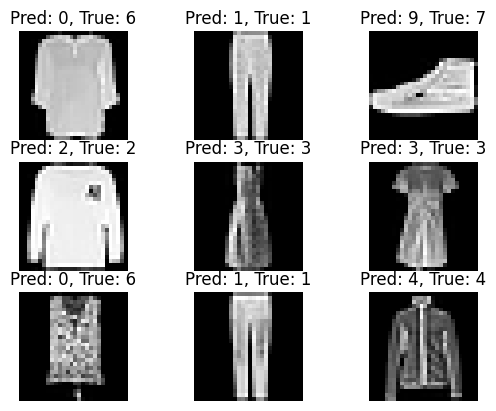

In [21]:
# Get predictions
model.eval()
images, labels = next(iter(test_loader))
predictions = model(images).argmax(dim=1)

# Plot 9 images
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {predictions[i]}, True: {labels[i]}")
    plt.axis('off')
plt.show()
